In [1]:
from spineq.optimise import *
from spineq.plotting import *

import pandas as pd

## Inputs

In [2]:
n_sensors = 20
theta = 250

# Objective weightings/parameters
# Mostly for combined objectives optimisation
# Set a weight to 0 to not include that objective
population_weight = 0.5
workplace_weight = 0.5
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 1},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1},
}

# For Cambridge-style optimisation only
# How many sensors for each objective
sensors_per_objective = {
    "workplace": 5,
    "pop_total": 5,
    "pop_children": 5,
    "pop_elderly": 5,
}

## Pre-calculate some weights to re-use later

In [3]:

objective_weights = calc_oa_weights(population_weight=population_weight,
                                    workplace_weight=workplace_weight,
                                    pop_age_groups=pop_age_groups,
                                    combine=False)

weights_combined = calc_oa_weights(population_weight=population_weight,
                                   workplace_weight=workplace_weight,
                                   pop_age_groups=pop_age_groups,
                                   combine=True)


objective_weights["combined"] = weights_combined

objective_weights

,pop_total,pop_children,pop_elderly,workplace,combined
oa11cd,,,,,
E00042044,0.000785,0.000647,0.001238,0.000260,0.000575
E00042052,0.000996,0.000839,0.001631,0.000145,0.000650
E00042054,0.000989,0.001363,0.000936,0.000115,0.000605
E00042055,0.001056,0.001153,0.001238,0.000943,0.001046
E00042058,0.000453,0.000804,0.000211,0.000151,0.000320
...,...,...,...,...,...
E00042600,0.002684,0.000472,0.000634,0.001813,0.001538
E00042873,0.001264,0.001346,0.000272,0.001076,0.001018
E00042877,0.002541,0.003495,0.000211,0.000284,0.001183


## Slightly modified single objective greedy optimisation function

In [4]:
def greedy_single_obj(
    oa_x,
    oa_y,
    oa_weight,
    oa11cd,
    n_sensors=20,
    theta=500,
):
    n_poi = len(oa_x)

    # Compute coverage matrix: coverage at each OA due to a sensor placed at
    #  any other OA.
    coverage = coverage_matrix(oa_x, oa_y, theta=theta)

    # binary array - 1 if sensor at this location, 0 if not
    sensors = np.zeros(n_poi)

    # coverage obtained with each number of sensors
    placement_history = []
    coverage_history = []
    oa_coverage = []
    
    for s in range(n_sensors):
        # greedily add sensors
        print("Placing sensor", s + 1, "out of", n_sensors, "... ", end="")

        # initialise arrays to store best result so far
        best_total_coverage = 0
        best_sensors = sensors.copy()
        best_oa_coverage = sensors.copy()

        for site in range(n_poi):
            # try adding sensor at potential sensor site

            if sensors[site] == 1:
                # already have a sensor here, so skip to next
                continue

            else:
                new_sensors = sensors.copy()
                new_sensors[site] = 1

                # only keep coverages due to sites where a sensor is present
                mask_cov = np.multiply(coverage, new_sensors[np.newaxis, :])

                # coverage at each site = coverage due to nearest sensor
                max_mask_cov = np.max(mask_cov, axis=1)

                # Avg coverage = weighted sum across all points of interest
                new_coverage = (oa_weight * max_mask_cov).sum() / oa_weight.sum()

                if new_coverage > best_total_coverage:
                    # this site is the best site for next sensor found so far
                    best_new_site = oa11cd[site]
                    best_sensors = new_sensors.copy()
                    best_total_coverage = new_coverage
                    best_oa_coverage = max_mask_cov

        sensors = best_sensors.copy()
        placement_history.append(best_new_site)
        coverage_history.append(best_total_coverage)
        oa_coverage = best_oa_coverage.copy()

        print("coverage = {:.2f}".format(best_total_coverage))
        
    result = make_result_dict(
        n_sensors,
        theta,
        oa_x,
        oa_y,
        oa11cd,
        sensors,
        best_total_coverage,
        oa_coverage,
        placement_history,
        coverage_history,
        oa_weight=oa_weight,
    )

    return result

## Run separate optimisation for each individual objective

In [5]:
data = get_optimisation_inputs(population_weight=population_weight,
                               workplace_weight=workplace_weight,
                               pop_age_groups=pop_age_groups,
                               combine=False)

oa_x = data["oa_x"]
oa_y = data["oa_y"]
oa_weight = data["oa_weight"]
oa11cd = data["oa11cd"]

if type(oa_weight) is dict:
    print("Number of Objectives:", len(oa_weight))
    results = {}
    for name, weights in oa_weight.items():
        print("="*30)
        print("Doing", name)
        print("="*30)
        results[name] = greedy_single_obj(
            oa_x,
            oa_y,
            weights,
            oa11cd,
            n_sensors=n_sensors,
            theta=theta
        )

else:
    result = greedy_single_obj(
        oa_x,
        oa_y,
        oa_weight,
        oa11cd,
        n_sensors=n_sensors,
        theta=theta
    )
     

Number of Objectives: 4
Doing pop_total
Placing sensor 1 out of 20 ... coverage = 0.02
Placing sensor 2 out of 20 ... coverage = 0.04
Placing sensor 3 out of 20 ... coverage = 0.05
Placing sensor 4 out of 20 ... coverage = 0.06
Placing sensor 5 out of 20 ... coverage = 0.07
Placing sensor 6 out of 20 ... coverage = 0.08
Placing sensor 7 out of 20 ... coverage = 0.09
Placing sensor 8 out of 20 ... coverage = 0.10
Placing sensor 9 out of 20 ... coverage = 0.11
Placing sensor 10 out of 20 ... coverage = 0.11
Placing sensor 11 out of 20 ... coverage = 0.12
Placing sensor 12 out of 20 ... coverage = 0.13
Placing sensor 13 out of 20 ... coverage = 0.13
Placing sensor 14 out of 20 ... coverage = 0.14
Placing sensor 15 out of 20 ... coverage = 0.15
Placing sensor 16 out of 20 ... coverage = 0.15
Placing sensor 17 out of 20 ... coverage = 0.16
Placing sensor 18 out of 20 ... coverage = 0.17
Placing sensor 19 out of 20 ... coverage = 0.17
Placing sensor 20 out of 20 ... coverage = 0.18
Doing pop

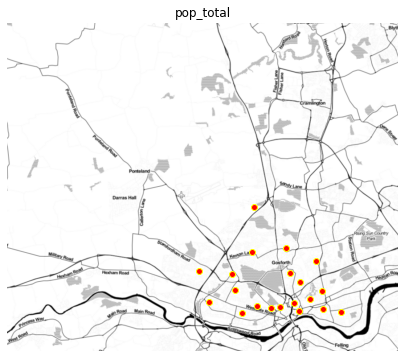

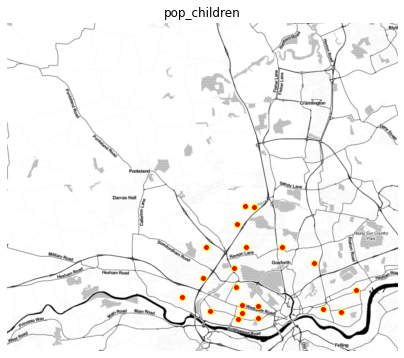

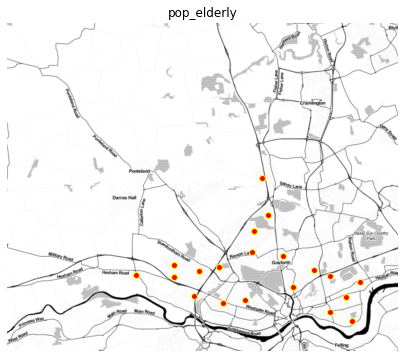

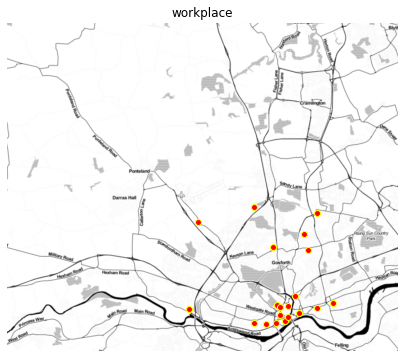

In [6]:
for name, result in results.items():
    plot_optimisation_result(result, title=name, figsize=(7,7), fill_oa=False,
                             sensor_edgecolor="yellow", sensor_color="red")


## Select Top Sensors for Each Objective to Create Combined (Cambridge-Style) Network

In [7]:
# sort sensors_per_objective by number of sensors to be placed
sensors_per_objective = {
    k: v for k, v in sorted(
        sensors_per_objective.items(),
        key=lambda item: item[1],
        reverse=True
    )
}

# Add number of sensors defined by sensors_per_objective to final network,
# avoiding duplicates.
chosen_oa = []

for name, result in results.items():
    print(name,":", result["placement_history"][:sensors_per_objective[name]])
    top_oa = result["placement_history"][:sensors_per_objective[name]]
    for oa in top_oa:
        if oa not in chosen_oa:
            chosen_oa.append(oa)

# Add more sensors until total matches number of sensors defined in
# sensors_per_objective. Added in objective priority order, so additional
# sensor most likely to be added to objective with most requested sensors.
shift = 0
candidate_oa = []
while len(chosen_oa) < sum(sensors_per_objective.values()):
    shift += 1
    
    for objective, n in sensors_per_objective.items():
        oa = results[objective]["placement_history"][n+shift-1]
        if oa not in chosen_oa:
            print("Adding", oa, ", rank", n+shift, "for", objective)
            chosen_oa.append(oa)
            if len(chosen_oa) == sum(sensors_per_objective.values()):
                break
            
print("="*50)
print("NETWORK:")
print(chosen_oa)
print(len(chosen_oa))

pop_total : ['E00042820', 'E00042672', 'E00042262', 'E00042447', 'E00042433']
pop_children : ['E00042262', 'E00042608', 'E00175591', 'E00042888', 'E00042570']
pop_elderly : ['E00042846', 'E00042713', 'E00042228', 'E00042417', 'E00042174']
workplace : ['E00042580', 'E00175551', 'E00042371', 'E00175577', 'E00042583']
Adding E00042207 , rank 6 for workplace
NETWORK:
['E00042820', 'E00042672', 'E00042262', 'E00042447', 'E00042433', 'E00042608', 'E00175591', 'E00042888', 'E00042570', 'E00042846', 'E00042713', 'E00042228', 'E00042417', 'E00042174', 'E00042580', 'E00175551', 'E00042371', 'E00175577', 'E00042583', 'E00042207']
20


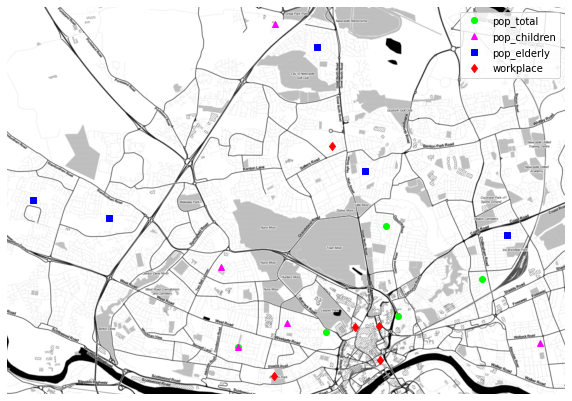

In [8]:
from spineq.data_fetcher import get_oa_centroids, get_oa_shapes
import matplotlib.pyplot as plt
import contextily as ctx
from distinctipy import distinctipy
import numpy as np
%matplotlib inline

oa_shapes = get_oa_shapes()
centroids = get_oa_centroids()

# avoid greyscales as marker colours (used on maps)
exclude_colors = [(x, x, x) for x in np.linspace(0,1,11)]

n_objectives = len(sensors_per_objective)

colors = distinctipy.get_colors(n_objectives,
                                exclude_colors=exclude_colors)
sensor_colors = {name: colors[i] for i, name in enumerate(results.keys())}

markers = ["o", "^", "s", "d"]
sensor_markers = {name: markers[i] for i, name in enumerate(results.keys())}

fig, ax = plt.subplots(1,1, figsize=(10,10))

for name, result in results.items():
    s = centroids.loc[result["placement_history"][:sensors_per_objective[name]]]
    ax.plot(s["x"], s["y"], label=name,
            marker=sensor_markers[name],
            color=sensor_colors[name],
            linestyle="none")

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=oa_shapes.crs.to_epsg(),
)
ax.set_axis_off()
plt.legend()

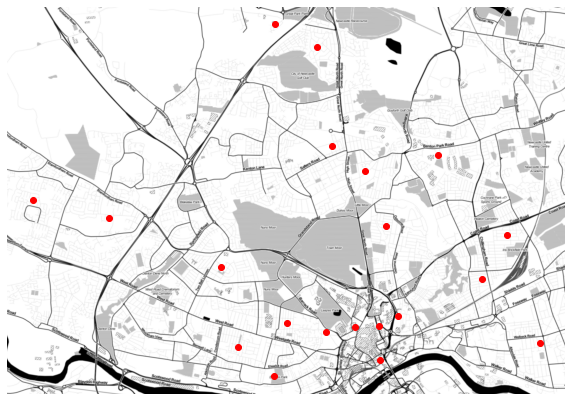

In [9]:
centroids = get_oa_centroids()

fig, ax = plt.subplots(1,1, figsize=(10,10))

s = centroids.loc[chosen_oa]
ax.plot(s["x"], s["y"], 'ro')

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=oa_shapes.crs.to_epsg(),
)
ax.set_axis_off()

## Previous Approach: Weighted objectives in a single optimisation

In [10]:
data = get_optimisation_inputs(population_weight=population_weight,
                               workplace_weight=workplace_weight,
                               pop_age_groups=pop_age_groups,
                               combine=True)

oa_x = data["oa_x"]
oa_y = data["oa_y"]
oa_weight = data["oa_weight"]
oa11cd = data["oa11cd"]

result_combined = greedy_single_obj(
    oa_x,
    oa_y,
    oa_weight,
    oa11cd,
    n_sensors=n_sensors,
    theta=theta
)

Placing sensor 1 out of 20 ... coverage = 0.05
Placing sensor 2 out of 20 ... coverage = 0.09
Placing sensor 3 out of 20 ... coverage = 0.11
Placing sensor 4 out of 20 ... coverage = 0.13
Placing sensor 5 out of 20 ... coverage = 0.15
Placing sensor 6 out of 20 ... coverage = 0.17
Placing sensor 7 out of 20 ... coverage = 0.19
Placing sensor 8 out of 20 ... coverage = 0.20
Placing sensor 9 out of 20 ... coverage = 0.21
Placing sensor 10 out of 20 ... coverage = 0.22
Placing sensor 11 out of 20 ... coverage = 0.23
Placing sensor 12 out of 20 ... coverage = 0.24
Placing sensor 13 out of 20 ... coverage = 0.25
Placing sensor 14 out of 20 ... coverage = 0.26
Placing sensor 15 out of 20 ... coverage = 0.26
Placing sensor 16 out of 20 ... coverage = 0.27
Placing sensor 17 out of 20 ... coverage = 0.28
Placing sensor 18 out of 20 ... coverage = 0.29
Placing sensor 19 out of 20 ... coverage = 0.29
Placing sensor 20 out of 20 ... coverage = 0.30


Text(0.5, 1.0, 'COMBINED WEIGHTINGS')

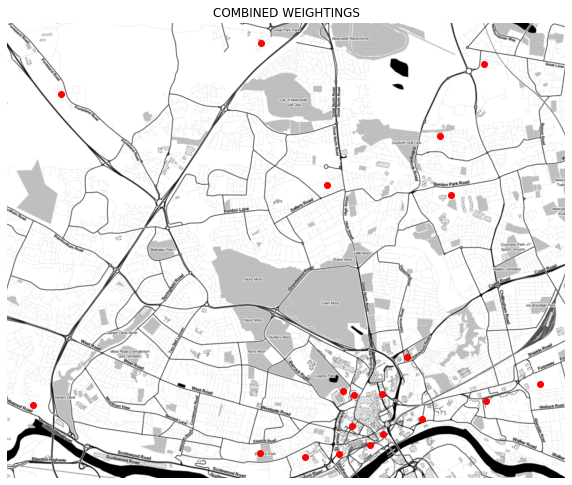

In [11]:
centroids = get_oa_centroids()

fig, ax = plt.subplots(1,1, figsize=(10,10))

s = centroids.loc[result["placement_history"]]
ax.plot(s["x"], s["y"], 'ro')

ctx.add_basemap(
    ax,
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=oa_shapes.crs.to_epsg(),
)
ax.set_axis_off()
ax.set_title("COMBINED WEIGHTINGS")

## Compare Approaches

Text(0.5, 1.0, 'CAMBRIDGE STYLE')

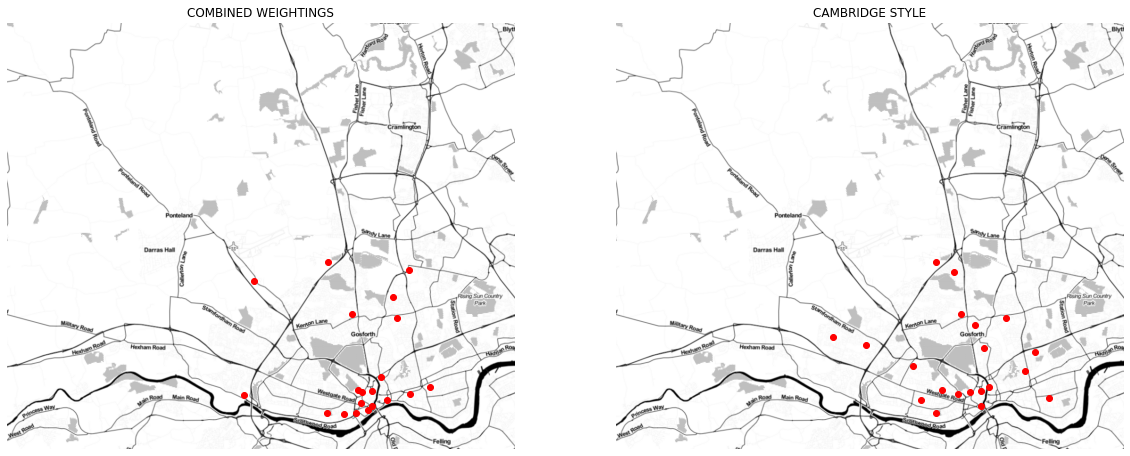

In [12]:
centroids = get_oa_centroids()

fig, ax = plt.subplots(1, 2, figsize=(20,10))

s = centroids.loc[result["placement_history"]]
ax[0].plot(s["x"], s["y"], 'ro')

oa_shapes.plot(ax=ax[0], edgecolor="none", facecolor="none")

ctx.add_basemap(
    ax[0],
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=oa_shapes.crs.to_epsg(),
)
ax[0].set_axis_off()
ax[0].set_title("COMBINED WEIGHTINGS")

s = centroids.loc[chosen_oa]
ax[1].plot(s["x"], s["y"], 'ro')

oa_shapes.plot(ax=ax[1], edgecolor="none", facecolor="none")

ctx.add_basemap(
    ax[1],
    source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
    crs=oa_shapes.crs.to_epsg(),
)
ax[1].set_axis_off()
ax[1].set_title("CAMBRIDGE STYLE")

In [13]:
# coverage of combined objectives optimisation for each individual objective
print("COMINBED SINGLE-OBJECTIVE OPTIMISATION")
print("="*30)
for obj in objective_weights.columns:
    cov = calc_coverage(result_combined["sensors"], objective_weights[obj], theta=theta)
    print(f"{obj}: {cov['total_coverage']:.3f}")

COMINBED SINGLE-OBJECTIVE OPTIMISATION
pop_total: 0.098
pop_children: 0.081
pop_elderly: 0.053
workplace: 0.525
combined: 0.301


In [14]:
# coverage of "Cambridge-style" network for each individual objective
print("CAMBRIDGE-STYLE OPTIMISATION")
print("="*30)
chosen_sensors = [{"oa11cd": oa} for oa in chosen_oa]
for obj in objective_weights.columns:
    cov = calc_coverage(chosen_sensors, objective_weights[obj], theta=theta)
    print(f"{obj}: {cov['total_coverage']:.3f}")

CAMBRIDGE-STYLE OPTIMISATION
pop_total: 0.151
pop_children: 0.128
pop_elderly: 0.102
workplace: 0.357
combined: 0.242


In [15]:
# Number of Top OAs for each objective (by placement history) in each network
check_top_n = 10
for name, result in results.items():
    print(name.upper())
    top_n = result["placement_history"][:check_top_n]
    in_combined = sum([s in result_combined["placement_history"] for s in top_n])
    print("Combined weights Network:", in_combined , "of top", check_top_n, "OA")
    in_cambridge = sum([s in chosen_oa for s in top_n])
    print("Cambridge-style Network :", in_cambridge, "of top", check_top_n, "OA")
    print("-"*30)


POP_TOTAL
Combined weights Network: 0 of top 10 OA
Cambridge-style Network : 6 of top 10 OA
------------------------------
POP_CHILDREN
Combined weights Network: 1 of top 10 OA
Cambridge-style Network : 5 of top 10 OA
------------------------------
POP_ELDERLY
Combined weights Network: 0 of top 10 OA
Cambridge-style Network : 5 of top 10 OA
------------------------------
WORKPLACE
Combined weights Network: 10 of top 10 OA
Cambridge-style Network : 6 of top 10 OA
------------------------------
